### TP Minería de Datos - Aprendizaje No Supervisado  

In [1]:
# AUXILIAR: IMPORTS GLOBALES
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import KFold

from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
# Carga de datos
df = pd.read_csv('../datasets/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


#### LIMPIEZA

In [3]:
# Análisis general
print("\nInfo general del dataset:")
df.info()

print("\nValores nulos:", df.isnull().sum().sum())
print("Valores duplicados:", df.duplicated().sum())


Info general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-nu

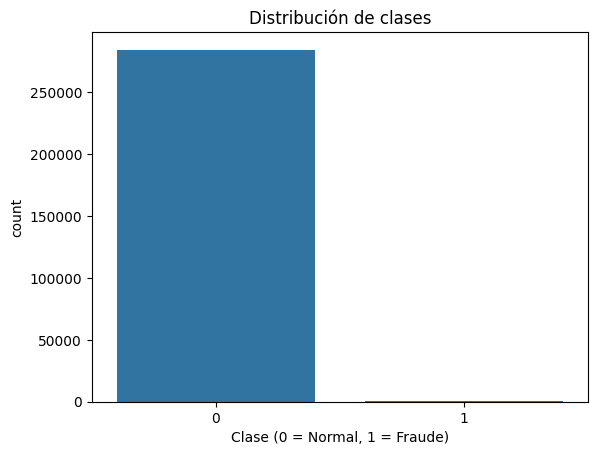


Porcentaje por clase:
Class
0    99.827251
1     0.172749
Name: proportion, dtype: float64


In [4]:
# Análisis de desbalance
sns.countplot(x='Class', data=df)
plt.title("Distribución de clases")
plt.xlabel("Clase (0 = Normal, 1 = Fraude)")
plt.show()

print("\nPorcentaje por clase:")
print(df['Class'].value_counts(normalize=True) * 100)

#### INTEGRACIÓN
No se requiere integración de datos, ya que se trabaja con un solo dataset consolidado.

#### TRANSFORMACIÓN

In [5]:
# Transformamos segundos en horas (suponiendo inicio desde 0)
df['Hour'] = (df['Time'] / 3600) % 24
df = df.drop(columns=['Time'])

# Transformación logarítmica del monto para reducir skew
df['Amount_log'] = np.log1p(df['Amount'])  # log(1 + x) para evitar log(0)
df = df.drop(columns=['Amount'])

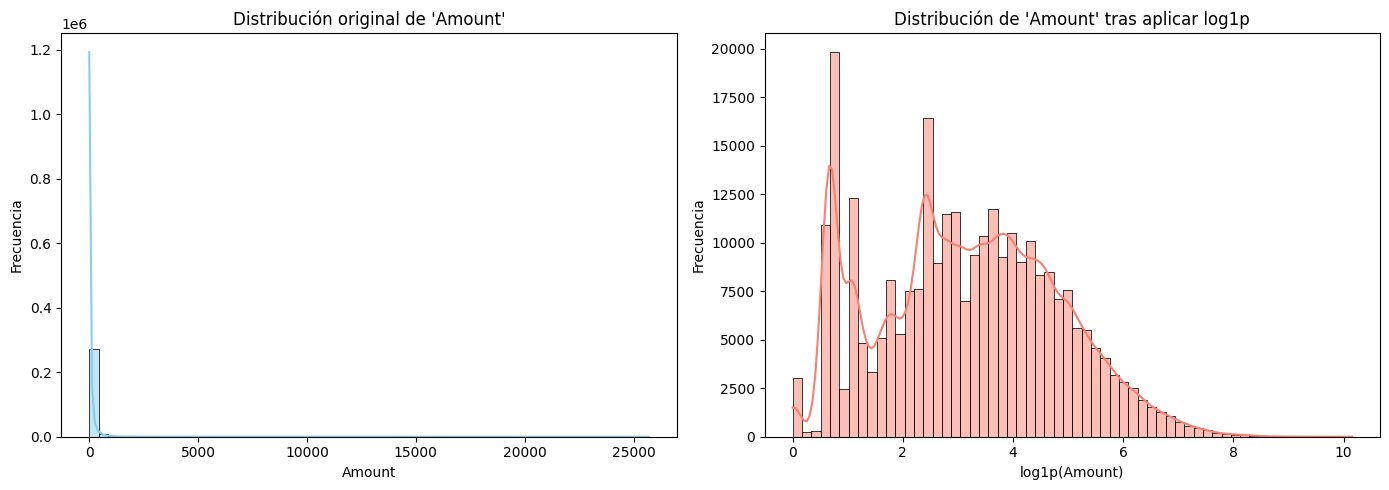

In [6]:
# Comparación visual de Amount antes y después del log1p.

df_raw = pd.read_csv('../datasets/creditcard.csv')
df_raw['Amount_log'] = np.log1p(df_raw['Amount'])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original
sns.histplot(df_raw['Amount'], bins=60, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title("Distribución original de 'Amount'")
axes[0].set_xlabel("Amount")
axes[0].set_ylabel("Frecuencia")

# Transformada
sns.histplot(df_raw['Amount_log'], bins=60, kde=True, ax=axes[1], color='salmon')
axes[1].set_title("Distribución de 'Amount' tras aplicar log1p")
axes[1].set_xlabel("log1p(Amount)")
axes[1].set_ylabel("Frecuencia")

plt.tight_layout()
plt.show()

In [7]:
# Guardamos las etiquetas solo para evaluación
y_true = df["Class"]

# Eliminamos las etiquetas para el entrenamiento
X = df.drop(columns=["Class"])

# Estandarizamos los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### MINERÍA

In [8]:
# Primera iteración: IsolationForest

kf = KFold(n_splits=5, shuffle=True, random_state=42)

precision_list = []
recall_list = []
f1_list = []

for fold, (train_index, test_index) in enumerate(kf.split(X_scaled), 1):
    print(f"---- Fold {fold} ----")

    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_test = y_true.iloc[test_index]

    model = IsolationForest(contamination=0.01, random_state=42)
    model.fit(X_train)

    y_pred = model.predict(X_test)
    y_pred = np.where(y_pred == 1, 0, 1)  # 1 = anomalía, 0 = normal

    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

---- Fold 1 ----
Precision: 0.1101, Recall: 0.6327, F1: 0.1876
---- Fold 2 ----
Precision: 0.1075, Recall: 0.6452, F1: 0.1843
---- Fold 3 ----
Precision: 0.1057, Recall: 0.6211, F1: 0.1807
---- Fold 4 ----
Precision: 0.0896, Recall: 0.5050, F1: 0.1522
---- Fold 5 ----
Precision: 0.1227, Recall: 0.7048, F1: 0.2090


In [9]:
# Segunda iteración: IsolationForest + Grid Search

kf = KFold(n_splits=5, shuffle=True, random_state=42)

precision_list = []
recall_list = []
f1_list = []

for fold, (train_index, test_index) in enumerate(kf.split(X_scaled), 1):
    print(f"---- Fold {fold} ----")

    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_test = y_true.iloc[test_index]

    model = IsolationForest(contamination=0.005, max_samples=0.5, n_estimators=200, random_state=42)
    model.fit(X_train)

    y_pred = model.predict(X_test)
    y_pred = np.where(y_pred == 1, 0, 1)  # 1 = anomalía, 0 = normal

    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

---- Fold 1 ----
Precision: 0.1898, Recall: 0.5714, F1: 0.2850
---- Fold 2 ----
Precision: 0.2000, Recall: 0.6022, F1: 0.3003
---- Fold 3 ----
Precision: 0.2111, Recall: 0.6000, F1: 0.3123
---- Fold 4 ----
Precision: 0.1986, Recall: 0.5545, F1: 0.2924
---- Fold 5 ----
Precision: 0.2194, Recall: 0.6667, F1: 0.3302


In [10]:
# Segunda iteración: Explorar hiperparámetros con Grid Search.
from sklearn.model_selection import ParameterGrid

"""
Se aplica una versión manual de Grid Search combinada con K-Fold,
buscando la combinación óptima de hiperparámetros para la métrica
F1 Score.

Se hace manual ya que la versión automática GridSearchCV espera
como parámetro un clasificador (y) el cual no solo usa para testear,
sino para entrenar, lo que en este caso rompe con la idea de aprendizaje
no supervisado.
"""

# Parámetros a explorar
param_grid = {
    'n_estimators': [100, 200],
    'max_samples': ['auto', 0.5],
    'contamination': [0.005, 0.01, 0.02]
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
mejor_f1 = 0
mejores_params = None

print("Buscando mejores hiperparámetros...\n")

# Para cada combinación de hiperparámetros
for params in ParameterGrid(param_grid):
    f1_scores = []
    print(f"Probando combinación: {params}")
    
    for fold, (train_index, test_index) in enumerate(kf.split(X_scaled), 1):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_test = y_true.iloc[test_index]

        model = IsolationForest(**params, random_state=42)
        model.fit(X_train)

        y_pred = (model.predict(X_test) == -1).astype(int)

        f1 = f1_score(y_test, y_pred, zero_division=0)
        f1_scores.append(f1)
    
    f1_avg = np.mean(f1_scores)
    print(f"F1 promedio: {f1_avg:.4f}\n")

    if f1_avg > mejor_f1:
        mejor_f1 = f1_avg
        mejores_params = params

print("🔍 Mejores hiperparámetros encontrados:")
print(mejores_params)
print(f"F1 promedio: {mejor_f1:.4f}")

Buscando mejores hiperparámetros...

Probando combinación: {'contamination': 0.005, 'max_samples': 'auto', 'n_estimators': 100}
F1 promedio: 0.2354

Probando combinación: {'contamination': 0.005, 'max_samples': 'auto', 'n_estimators': 200}


KeyboardInterrupt: 

#### EVALUACIÓN

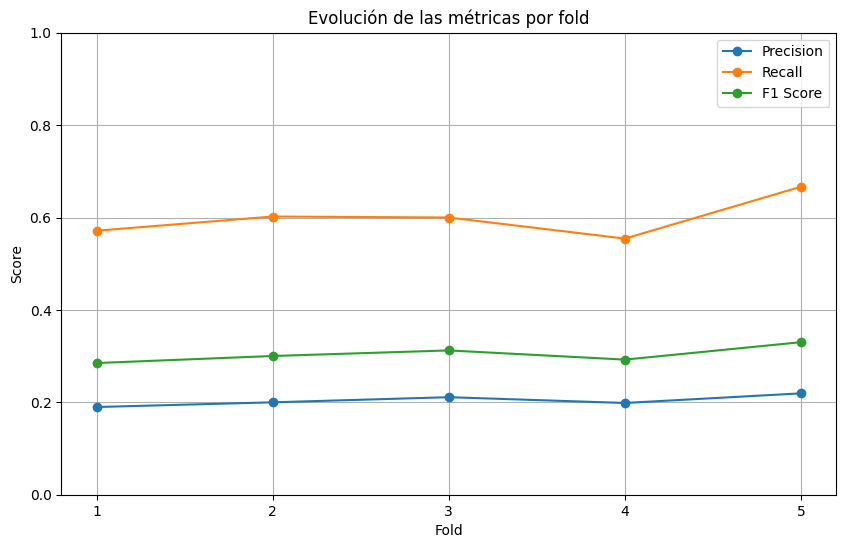

In [ ]:
folds = np.arange(1, len(precision_list) + 1)

plt.figure(figsize=(10, 6))
plt.plot(folds, precision_list, marker='o', label='Precision')
plt.plot(folds, recall_list, marker='o', label='Recall')
plt.plot(folds, f1_list, marker='o', label='F1 Score')

plt.title('Evolución de las métricas por fold')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.xticks(folds)
plt.ylim(0, 1)
plt.legend()
plt.grid()
plt.show()

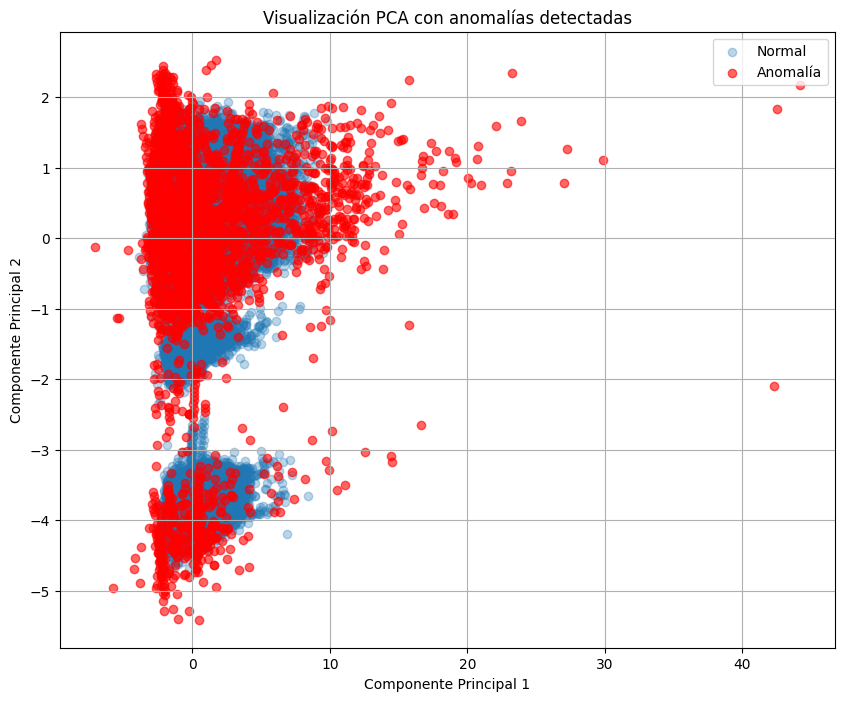

In [ ]:
final_model = IsolationForest(contamination=0.01, random_state=42)
final_model.fit(X_scaled)
df["Anomaly"] = final_model.predict(X_scaled)
df["Anomaly"] = df["Anomaly"].map({1: 0, -1: 1})

# Reducimos dimensionalidad para graficar
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualización
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[df["Anomaly"] == 0, 0], X_pca[df["Anomaly"] == 0, 1], alpha=0.3, label='Normal')
plt.scatter(X_pca[df["Anomaly"] == 1, 0], X_pca[df["Anomaly"] == 1, 1], color='red', alpha=0.6, label='Anomalía')

plt.title('Visualización PCA con anomalías detectadas')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.grid()
plt.show()